### **Import Libraries**

In [54]:
# Suppress warnings and configure logging
import os
import warnings
warnings.filterwarnings("ignore")
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress Optuna logs except warnings

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# PyTorch
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.nn import Dropout

# Sklearn utilities and metrics
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, 
    RandomizedSearchCV, GridSearchCV
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

# External libraries for specialized models
from interpret.glassbox import ExplainableBoostingClassifier 
from ngboost import NGBClassifier 
from ngboost.distns import Bernoulli 
from ngboost.scores import LogScore  
from snapml import BoostingMachineClassifier  
from tab_transformer_pytorch import TabTransformer 
from pytorch_tabnet.tab_model import TabNetClassifier  
import lightgbm as lgb  
import xgboost as xgb  

# Hyperparameter optimization tools
from skopt import BayesSearchCV 
from ray import tune  

# General environment configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs

### **Load & Split Data**

In [34]:
df = pd.read_csv('../data/cleaned_data.csv')

print('Sample Data')
display(df.head())

Sample Data


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168,62.0,110,80,0,0,0,0,1,0
1,55,0,156,85.0,140,90,2,0,0,0,1,1
2,51,0,165,64.0,130,70,2,0,0,0,0,1
3,48,1,169,82.0,150,100,0,0,0,0,1,1
4,60,0,151,67.0,120,80,1,1,0,0,0,0


In [35]:
X = df.drop('cardio', axis=1)  
y = df['cardio']   

In [68]:
label_mapping = {0: 'Healthy', 1: 'Cardio Risk'}
target_names = [label_mapping[label] for label in y.unique()]

### **Scaling Data**

In [37]:
standard_features = ['age', 'height', 'weight','ap_hi', 'ap_lo']
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

assert all(feature in X.columns for feature in standard_features + categorical_features)

In [38]:
scaler_standard = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('standard', scaler_standard, standard_features)
    ],
    remainder='passthrough'  # Leave categorical/binary features unchanged
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_preprocessed = pipeline.fit_transform(X)

X_preprocessed = pd.DataFrame(X_preprocessed, columns=standard_features + categorical_features)
X_preprocessed

,age,height,weight,ap_hi,ap_lo,gender,cholesterol,gluc,smoke,alco,active
0,-0.430672,0.442133,-0.868692,-1.155890,-0.231847,1.0,0.0,0.0,0.0,0.0,1.0
1,0.310816,-1.068773,0.760896,0.929804,1.064857,0.0,2.0,0.0,0.0,0.0,1.0
2,-0.282375,0.064407,-0.726988,0.234572,-1.528550,0.0,2.0,0.0,0.0,0.0,0.0
3,-0.727268,0.568042,0.548341,1.625035,2.361560,1.0,0.0,0.0,0.0,0.0,1.0
4,1.052305,-1.698317,-0.514434,-0.460659,-0.231847,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
64462,0.607412,0.064407,0.406638,1.625035,-0.231847,0.0,0.0,0.0,0.0,0.0,1.0
64463,-0.134077,0.442133,0.123231,-0.460659,-0.231847,1.0,0.0,0.0,1.0,0.0,1.0
64464,1.200603,-0.816955,3.665814,0.929804,1.064857,0.0,1.0,1.0,0.0,0.0,1.0
64465,1.200603,-0.187411,-0.160175,0.582188,-0.231847,0.0,0.0,1.0,0.0,0.0,0.0


### **Train, Val, Test**

In [39]:
x_train, x_temp, y_train, y_temp = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)  # Train 70%
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=(1/3), random_state=42)  # Val 20%, Test 10%

In [40]:
# NumPy array format
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

### **Base Model**

#### **Explainable Boosting Machine (EBM)**

EBM Accuracy on Test Set: 0.7257

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.70      0.78      0.73      2097
 Cardio Risk       0.76      0.68      0.72      2201

    accuracy                           0.73      4298
   macro avg       0.73      0.73      0.73      4298
weighted avg       0.73      0.73      0.73      4298



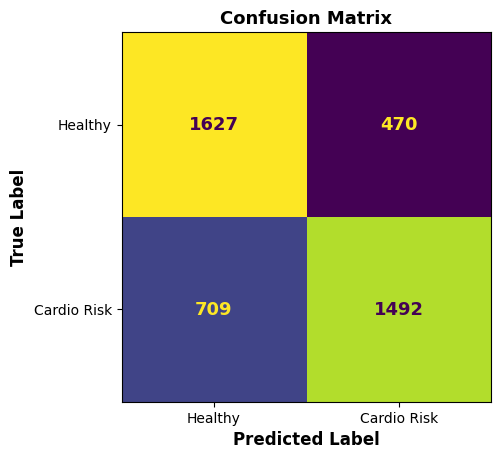

AUC Score on Test Set: 0.7970


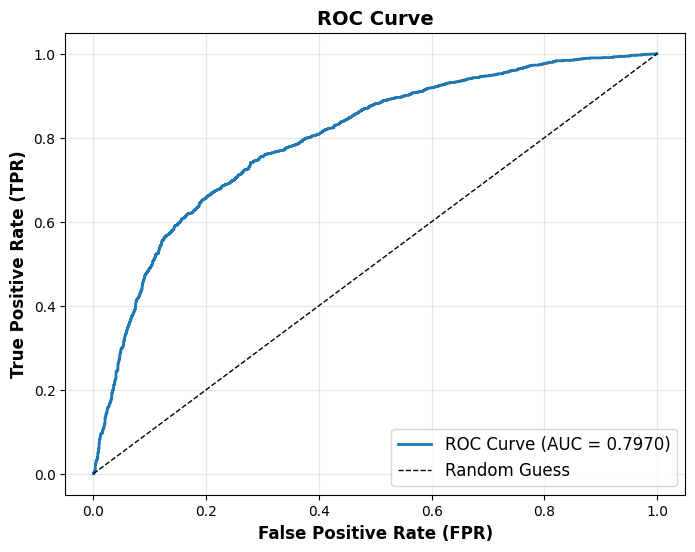

EBM Accuracy on Training Set: 0.7311
AUC Score on Training Set: 0.7980

Overfitting Check:
The model does not show significant signs of overfitting.


In [41]:
# Train the model
base_model_ebm = ExplainableBoostingClassifier()
base_model_ebm.fit(x_train_np, y_train_np)

# Predictions on test set
y_pred = base_model_ebm.predict(x_test_np)

# Accuracy on test set
accuracy = accuracy_score(y_test_np, y_pred)
print(f"EBM Accuracy on Test Set: {accuracy:.4f}")

# Classification report
report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

# ROC Curve and AUC Score
y_probs = base_model_ebm.predict_proba(x_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_np, y_probs)
auc_score = roc_auc_score(y_test_np, y_probs)
print(f"AUC Score on Test Set: {auc_score:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
plt.xlabel("False Positive Rate (FPR)", fontsize=12, fontweight='bold')
plt.ylabel("True Positive Rate (TPR)", fontsize=12, fontweight='bold')
plt.title("ROC Curve", fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Overfitting Check
y_train_pred = base_model_ebm.predict(x_train_np)
train_accuracy = accuracy_score(y_train_np, y_train_pred)
train_auc_score = roc_auc_score(y_train_np, base_model_ebm.predict_proba(x_train_np)[:, 1])

print(f"EBM Accuracy on Training Set: {train_accuracy:.4f}")
print(f"AUC Score on Training Set: {train_auc_score:.4f}")

# Compare training and test performance
print("\nOverfitting Check:")
if train_accuracy > accuracy + 0.05 or train_auc_score > auc_score + 0.05:
    print("The model might be overfitting. Training performance is significantly higher than test performance.")
else:
    print("The model does not show significant signs of overfitting.")

#### **NGBoost**

[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5599 val_loss=0.0000 scale=2.0000 norm=3.7961
[iter 200] loss=0.5500 val_loss=0.0000 scale=2.0000 norm=3.8839
[iter 300] loss=0.5470 val_loss=0.0000 scale=1.0000 norm=1.9594
[iter 400] loss=0.5457 val_loss=0.0000 scale=2.0000 norm=3.9347
NGBClassifier Accuracy on Test Set: 0.7236

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.70      0.77      0.73      2097
 Cardio Risk       0.76      0.68      0.72      2201

    accuracy                           0.72      4298
   macro avg       0.73      0.72      0.72      4298
weighted avg       0.73      0.72      0.72      4298



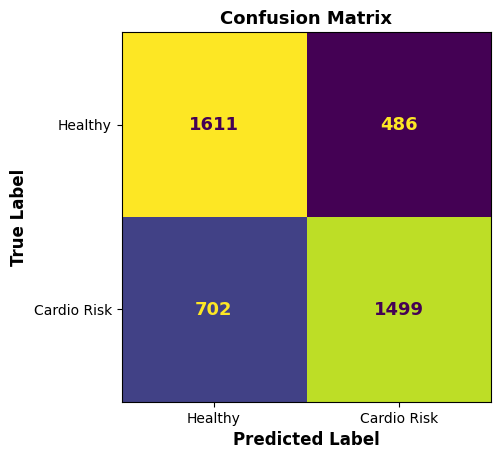

AUC Score on Test Set: 0.7974


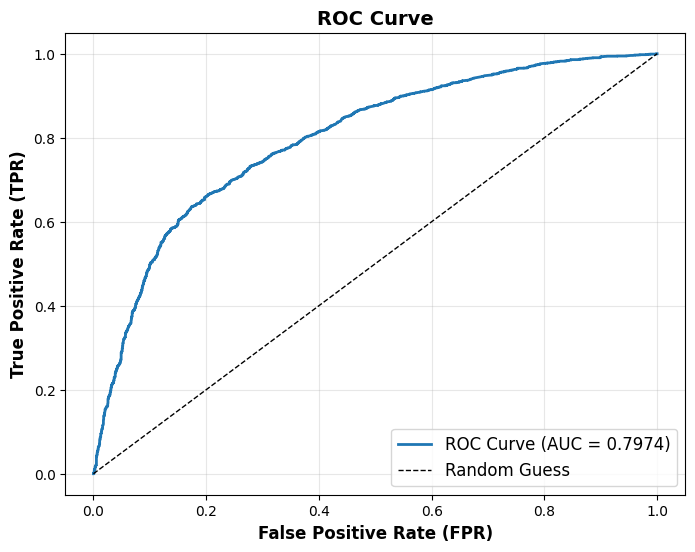

NGBClassifier Accuracy on Training Set: 0.7301
AUC Score on Training Set: 0.7983

Overfitting Check:
The model does not show significant signs of overfitting.


In [42]:
class NGBClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.ngb = NGBClassifier(**kwargs)
        self.classes_ = None

    def fit(self, X, y):
        self.ngb.fit(X, y)
        self.classes_ = np.unique(y)  # Define the classes explicitly
        return self

    def predict(self, X):
        return self.ngb.predict(X)

    def predict_proba(self, X):
        return self.ngb.predict_proba(X)

# Initialize and train the model
base_model_ngb = NGBClassifierWrapper(Dist=Bernoulli)
base_model_ngb.fit(x_train_np, y_train_np)

# Test set predictions
y_pred = base_model_ngb.predict(x_test_np)
accuracy = accuracy_score(y_test_np, y_pred)
print(f"NGBClassifier Accuracy on Test Set: {accuracy:.4f}")

# Classification report
report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

# ROC Curve and AUC Score
y_probs = base_model_ngb.predict_proba(x_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_np, y_probs)
auc_score = roc_auc_score(y_test_np, y_probs)
print(f"AUC Score on Test Set: {auc_score:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
plt.xlabel("False Positive Rate (FPR)", fontsize=12, fontweight='bold')
plt.ylabel("True Positive Rate (TPR)", fontsize=12, fontweight='bold')
plt.title("ROC Curve", fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Overfitting Check
y_train_pred = base_model_ngb.predict(x_train_np)
train_accuracy = accuracy_score(y_train_np, y_train_pred)
train_auc_score = roc_auc_score(y_train_np, base_model_ngb.predict_proba(x_train_np)[:, 1])

print(f"NGBClassifier Accuracy on Training Set: {train_accuracy:.4f}")
print(f"AUC Score on Training Set: {train_auc_score:.4f}")

# Compare training and test performance
print("\nOverfitting Check:")
if train_accuracy > accuracy + 0.05 or train_auc_score > auc_score + 0.05:
    print("The model might be overfitting. Training performance is significantly higher than test performance.")
else:
    print("The model does not show significant signs of overfitting.")

#### **SnapBoost**

SnapBoost Accuracy on Test Set: 0.7282

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.70      0.78      0.74      2097
 Cardio Risk       0.76      0.68      0.72      2201

    accuracy                           0.73      4298
   macro avg       0.73      0.73      0.73      4298
weighted avg       0.73      0.73      0.73      4298



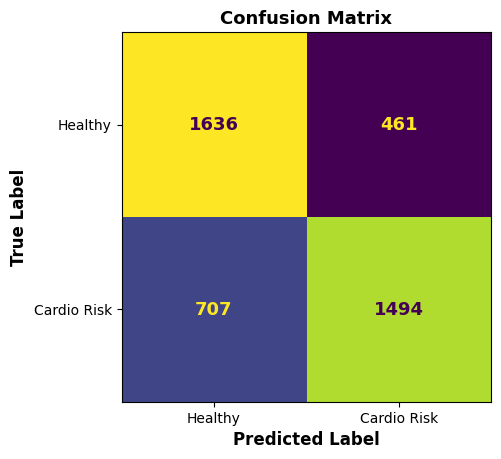

AUC Score on Test Set: 0.8000


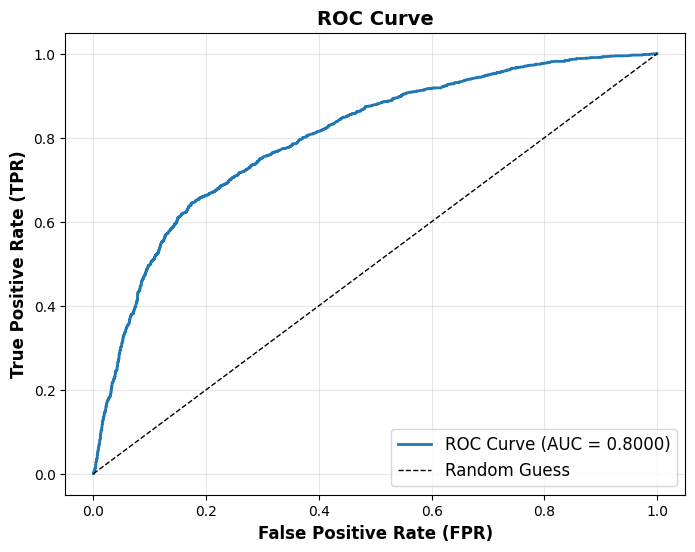

SnapBoost Accuracy on Training Set: 0.7348
AUC Score on Training Set: 0.8033

Overfitting Check:
The model does not show significant signs of overfitting.


In [43]:
# Initialize and train the SnapBoost model
base_model_snb = BoostingMachineClassifier()
base_model_snb.fit(x_train_np, y_train_np)

# Predictions on test set
y_pred = base_model_snb.predict(x_test_np)
accuracy = accuracy_score(y_test_np, y_pred)
print(f"SnapBoost Accuracy on Test Set: {accuracy:.4f}")

# Classification report
report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

# ROC Curve and AUC Score
y_probs = base_model_snb.predict_proba(x_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_np, y_probs)
auc_score = roc_auc_score(y_test_np, y_probs)
print(f"AUC Score on Test Set: {auc_score:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
plt.xlabel("False Positive Rate (FPR)", fontsize=12, fontweight='bold')
plt.ylabel("True Positive Rate (TPR)", fontsize=12, fontweight='bold')
plt.title("ROC Curve", fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Overfitting Check
y_train_pred = base_model_snb.predict(x_train_np)
train_accuracy = accuracy_score(y_train_np, y_train_pred)
train_auc_score = roc_auc_score(y_train_np, base_model_snb.predict_proba(x_train_np)[:, 1])

print(f"SnapBoost Accuracy on Training Set: {train_accuracy:.4f}")
print(f"AUC Score on Training Set: {train_auc_score:.4f}")

# Compare training and test performance
print("\nOverfitting Check:")
if train_accuracy > accuracy + 0.05 or train_auc_score > auc_score + 0.05:
    print("The model might be overfitting. Training performance is significantly higher than test performance.")
else:
    print("The model does not show significant signs of overfitting.")

#### **TabNet**

epoch 0  | loss: 0.61484 | val_0_accuracy: 0.71093 | val_1_accuracy: 0.70684 |  0:00:01s
epoch 1  | loss: 0.57684 | val_0_accuracy: 0.71342 | val_1_accuracy: 0.70638 |  0:00:02s
epoch 2  | loss: 0.57066 | val_0_accuracy: 0.71667 | val_1_accuracy: 0.71661 |  0:00:04s
epoch 3  | loss: 0.56459 | val_0_accuracy: 0.72092 | val_1_accuracy: 0.71685 |  0:00:05s
epoch 4  | loss: 0.56163 | val_0_accuracy: 0.72253 | val_1_accuracy: 0.71778 |  0:00:06s
epoch 5  | loss: 0.55979 | val_0_accuracy: 0.7233  | val_1_accuracy: 0.7222  |  0:00:08s
epoch 6  | loss: 0.55725 | val_0_accuracy: 0.7248  | val_1_accuracy: 0.72313 |  0:00:09s
epoch 7  | loss: 0.55626 | val_0_accuracy: 0.72689 | val_1_accuracy: 0.72894 |  0:00:11s
epoch 8  | loss: 0.55501 | val_0_accuracy: 0.72771 | val_1_accuracy: 0.72452 |  0:00:12s
epoch 9  | loss: 0.55379 | val_0_accuracy: 0.72813 | val_1_accuracy: 0.72732 |  0:00:13s
epoch 10 | loss: 0.55364 | val_0_accuracy: 0.72794 | val_1_accuracy: 0.72383 |  0:00:15s
epoch 11 | loss: 0.55

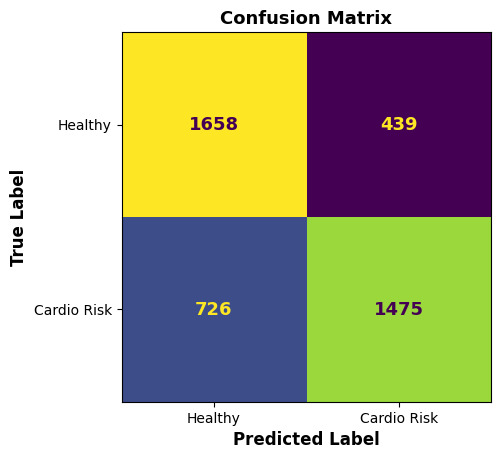

AUC Score on Test Set: 0.7912


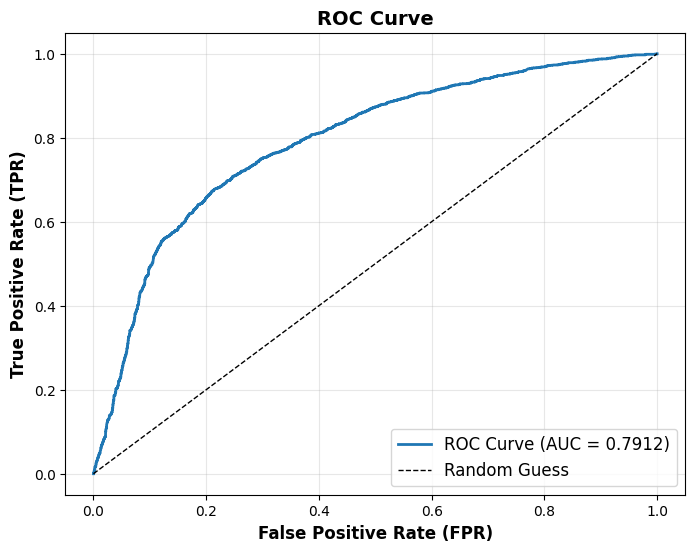

TabNet Accuracy on Training Set: 0.7269
AUC Score on Training Set: 0.7917

Overfitting Check:
The model does not show significant signs of overfitting.


In [44]:
# Initialize and train the TabNet model
base_model_tabnet = TabNetClassifier(seed=42)

base_model_tabnet.fit(
    x_train_np, y_train_np,
    eval_set=[(x_train_np, y_train_np), (x_test_np, y_test_np)],
    eval_metric=["accuracy"],
    max_epochs=50
)

# Predictions on the test set
y_pred = base_model_tabnet.predict(x_test_np)
accuracy = accuracy_score(y_test_np, y_pred)
print(f"TabNet Accuracy on Test Set: {accuracy:.4f}")

# Classification report
report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

# ROC Curve and AUC Score
y_probs = base_model_tabnet.predict_proba(x_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_np, y_probs)
auc_score = roc_auc_score(y_test_np, y_probs)
print(f"AUC Score on Test Set: {auc_score:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
plt.xlabel("False Positive Rate (FPR)", fontsize=12, fontweight='bold')
plt.ylabel("True Positive Rate (TPR)", fontsize=12, fontweight='bold')
plt.title("ROC Curve", fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Overfitting Check
y_train_pred = base_model_tabnet.predict(x_train_np)
train_accuracy = accuracy_score(y_train_np, y_train_pred)
train_auc_score = roc_auc_score(y_train_np, base_model_tabnet.predict_proba(x_train_np)[:, 1])

print(f"TabNet Accuracy on Training Set: {train_accuracy:.4f}")
print(f"AUC Score on Training Set: {train_auc_score:.4f}")

# Compare training and test performance
print("\nOverfitting Check:")
if train_accuracy > accuracy + 0.05 or train_auc_score > auc_score + 0.05:
    print("The model might be overfitting. Training performance is significantly higher than test performance.")
else:
    print("The model does not show significant signs of overfitting.")

#### **TabTransformer**

Epoch 1, Loss: 0.6368
Epoch 2, Loss: 0.6179
Epoch 3, Loss: 0.6181
Epoch 4, Loss: 0.6176
Epoch 5, Loss: 0.6169
Epoch 6, Loss: 0.6161
Epoch 7, Loss: 0.6159
Epoch 8, Loss: 0.6156
Epoch 9, Loss: 0.6146
Epoch 10, Loss: 0.6147
Epoch 11, Loss: 0.6136
Epoch 12, Loss: 0.6139
Epoch 13, Loss: 0.6134
Epoch 14, Loss: 0.6143
Epoch 15, Loss: 0.6115
Epoch 16, Loss: 0.6119
Epoch 17, Loss: 0.6120
Epoch 18, Loss: 0.6134
Epoch 19, Loss: 0.6117
Epoch 20, Loss: 0.6117
Early stopping at epoch 20
TabTransformer Accuracy on Test Set: 0.6750

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.64      0.75      0.69      2097
 Cardio Risk       0.72      0.60      0.66      2201

    accuracy                           0.67      4298
   macro avg       0.68      0.68      0.67      4298
weighted avg       0.68      0.67      0.67      4298



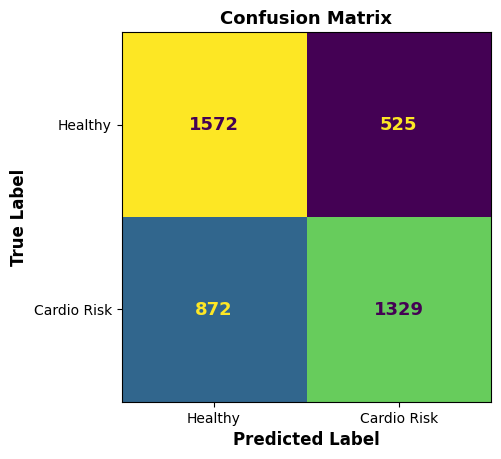

AUC Score on Test Set: 0.7312


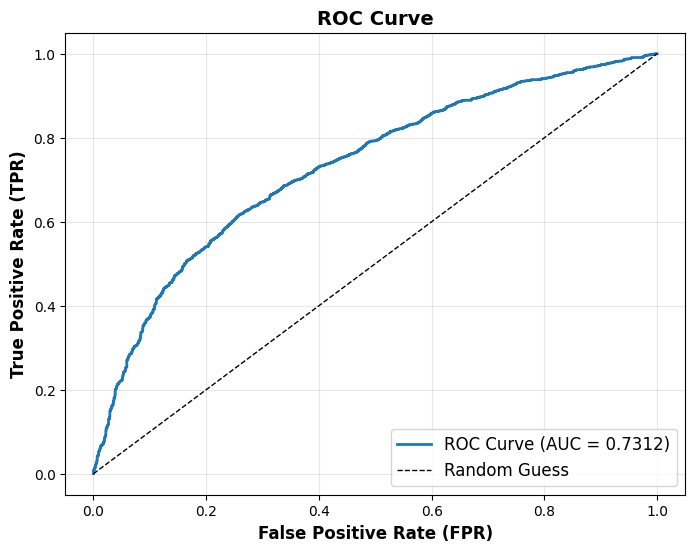

TabTransformer Accuracy on Training Set: 0.6834
AUC Score on Training Set: 0.7411

Overfitting Check:
The model does not show significant signs of overfitting.


In [55]:
# Define categorical and continuous indices
categorical_indices = [5, 6, 7, 8, 9, 10]
continuous_indices = [0, 1, 2, 3, 4]


class TabTransformerWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, categories, num_continuous, dim=32, depth=4, heads=4, dim_out=1, lr=0.001, epochs=50, batch_size=64, patience=5):
        self.categories = categories
        self.num_continuous = num_continuous
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dim_out = dim_out
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.patience = patience
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = None

    def _initialize_model(self):
        """Initialize the TabTransformer model."""
        from tab_transformer_pytorch import TabTransformer
        self.model = TabTransformer(
            categories=self.categories,
            num_continuous=self.num_continuous,
            dim=self.dim,
            depth=self.depth,
            heads=self.heads,
            dim_out=self.dim_out
        ).to(self.device)
        self.dropout = Dropout(p=0.1)  # Add dropout with probability 0.1
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-2)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self._initialize_model()

        # Prepare data
        x_categ = torch.tensor(X[:, categorical_indices], dtype=torch.long).to(self.device)
        x_cont = torch.tensor(X[:, continuous_indices], dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        dataset = torch.utils.data.TensorDataset(x_categ, x_cont, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # Early stopping variables
        best_loss = float("inf")
        patience_counter = 0
        best_model_state = None

        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss = 0
            for batch_x_categ, batch_x_cont, batch_y in dataloader:
                self.optimizer.zero_grad()
                preds = self.model(batch_x_categ, batch_x_cont).squeeze()
                preds = self.dropout(preds)  # Apply dropout here
                loss = self.loss_fn(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

            # Early stopping and monitoring
            epoch_loss /= len(dataloader)
            print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

            if epoch_loss < best_loss:
                best_loss = epoch_loss
                patience_counter = 0
                best_model_state = self.model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    self.model.load_state_dict(best_model_state)
                    break

        self.classes_ = np.array([0, 1])  # Assuming binary classification
        return self


    def predict(self, X):
        X = np.asarray(X)

        x_categ = torch.tensor(X[:, categorical_indices], dtype=torch.long).to(self.device)
        x_cont = torch.tensor(X[:, continuous_indices], dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(x_categ, x_cont).squeeze()
        return (torch.sigmoid(preds) > 0.5).cpu().numpy().astype(int)

    def predict_proba(self, X):
        X = np.asarray(X)

        x_categ = torch.tensor(X[:, categorical_indices], dtype=torch.long).to(self.device)
        x_cont = torch.tensor(X[:, continuous_indices], dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(x_categ, x_cont).squeeze()
        return np.column_stack((1 - torch.sigmoid(preds).cpu().numpy(), torch.sigmoid(preds).cpu().numpy()))


# Normalize continuous features
scaler = StandardScaler()
x_train_np[:, continuous_indices] = scaler.fit_transform(x_train_np[:, continuous_indices])
x_test_np[:, continuous_indices] = scaler.transform(x_test_np[:, continuous_indices])

# Initialize and train the TabTransformer model
base_model_tabtf = TabTransformerWrapper(
    categories=[2, 3, 3, 2, 2, 2],  # Number of unique values per categorical column
    num_continuous=len(continuous_indices),
    dim=32,
    depth=4,
    heads=4,
    dim_out=1,
    epochs=50,
    batch_size=64
)

# Fit the model on training data
base_model_tabtf.fit(x_train_np, y_train_np)

# Predictions on the test set
y_pred = base_model_tabtf.predict(x_test_np)
accuracy = accuracy_score(y_test_np, y_pred)
print(f"TabTransformer Accuracy on Test Set: {accuracy:.4f}")

# Classification report
report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

# ROC Curve and AUC Score
y_probs = base_model_tabtf.predict_proba(x_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_np, y_probs)
auc_score = roc_auc_score(y_test_np, y_probs)
print(f"AUC Score on Test Set: {auc_score:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
plt.xlabel("False Positive Rate (FPR)", fontsize=12, fontweight='bold')
plt.ylabel("True Positive Rate (TPR)", fontsize=12, fontweight='bold')
plt.title("ROC Curve", fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Overfitting Check
y_train_pred = base_model_tabtf.predict(x_train_np)
train_accuracy = accuracy_score(y_train_np, y_train_pred)
train_auc_score = roc_auc_score(y_train_np, base_model_tabtf.predict_proba(x_train_np)[:, 1])

print(f"TabTransformer Accuracy on Training Set: {train_accuracy:.4f}")
print(f"AUC Score on Training Set: {train_auc_score:.4f}")

# Compare training and test performance
print("\nOverfitting Check:")
if train_accuracy > accuracy + 0.05 or train_auc_score > auc_score + 0.05:
    print("The model might be overfitting. Training performance is significantly higher than test performance.")
else:
    print("The model does not show significant signs of overfitting.")

#### **Meta Model**

[LightGBM] [Info] Number of positive: 25619, number of negative: 25954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 51573, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496752 -> initscore=-0.012991
[LightGBM] [Info] Start training from score -0.012991
Meta-Model Accuracy on Test Set: 0.7257

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.70      0.77      0.73      2097
 Cardio Risk       0.76      0.68      0.72      2201

    accuracy                           0.73      4298
   macro avg       0.73      0.73      0.73      4298
weighted avg       0.73      0.73      0.73      4298



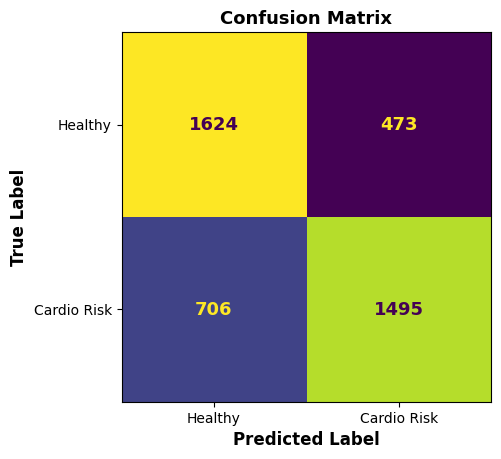

AUC Score on Test Set: 0.8003


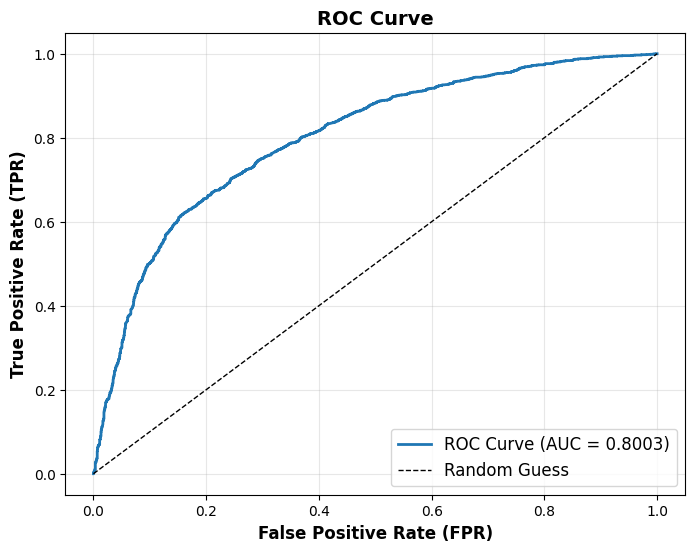

Meta-Model Accuracy on Training Set: 0.7431
AUC Score on Training Set: 0.8159

Overfitting Check:
The model does not show significant signs of overfitting.


In [56]:
# Initialize and train the LightGBM meta-model
meta_model_lgb = lgb.LGBMClassifier()
meta_model_lgb.fit(x_train_np, y_train_np)

# Predictions on the test set
y_pred = meta_model_lgb.predict(x_test_np)
accuracy = accuracy_score(y_test_np, y_pred)
print(f"Meta-Model Accuracy on Test Set: {accuracy:.4f}")

# Classification report
report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

# ROC Curve and AUC Score
y_probs = meta_model_lgb.predict_proba(x_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_np, y_probs)
auc_score = roc_auc_score(y_test_np, y_probs)
print(f"AUC Score on Test Set: {auc_score:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
plt.xlabel("False Positive Rate (FPR)", fontsize=12, fontweight='bold')
plt.ylabel("True Positive Rate (TPR)", fontsize=12, fontweight='bold')
plt.title("ROC Curve", fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Overfitting Check
y_train_pred = meta_model_lgb.predict(x_train_np)
train_accuracy = accuracy_score(y_train_np, y_train_pred)
train_auc_score = roc_auc_score(y_train_np, meta_model_lgb.predict_proba(x_train_np)[:, 1])

print(f"Meta-Model Accuracy on Training Set: {train_accuracy:.4f}")
print(f"AUC Score on Training Set: {train_auc_score:.4f}")

# Compare training and test performance
print("\nOverfitting Check:")
if train_accuracy > accuracy + 0.05 or train_auc_score > auc_score + 0.05:
    print("The model might be overfitting. Training performance is significantly higher than test performance.")
else:
    print("The model does not show significant signs of overfitting.")

#### **Stacking Model**

In [58]:
base_models = [
    ("ebc", base_model_ebm), ("ngb", base_model_ngb), ('snb', base_model_snb), 
    ('tabnet', base_model_tabnet), ('tabtf', base_model_tabtf)
]

In [59]:
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model_lgb
)

In [60]:
stacking_model.fit(x_train_np, y_train_np)

[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5599 val_loss=0.0000 scale=2.0000 norm=3.7961
[iter 200] loss=0.5500 val_loss=0.0000 scale=2.0000 norm=3.8839
[iter 300] loss=0.5470 val_loss=0.0000 scale=1.0000 norm=1.9594
[iter 400] loss=0.5457 val_loss=0.0000 scale=2.0000 norm=3.9347
epoch 0  | loss: 0.61258 |  0:00:00s
epoch 1  | loss: 0.56959 |  0:00:01s
epoch 2  | loss: 0.56462 |  0:00:02s
epoch 3  | loss: 0.56332 |  0:00:03s
epoch 4  | loss: 0.56057 |  0:00:04s
epoch 5  | loss: 0.55798 |  0:00:05s
epoch 6  | loss: 0.55795 |  0:00:06s
epoch 7  | loss: 0.55741 |  0:00:07s
epoch 8  | loss: 0.55608 |  0:00:08s
epoch 9  | loss: 0.55514 |  0:00:09s
epoch 10 | loss: 0.55539 |  0:00:10s
epoch 11 | loss: 0.55477 |  0:00:11s
epoch 12 | loss: 0.55386 |  0:00:12s
epoch 13 | loss: 0.5534  |  0:00:13s
epoch 14 | loss: 0.55368 |  0:00:14s
epoch 15 | loss: 0.55448 |  0:00:15s
epoch 16 | loss: 0.55352 |  0:00:16s
epoch 17 | loss: 0.55369 |  0:00:17s
epoch 18 | loss:

StackingClassifier(estimators=[('ebc', ExplainableBoostingClassifier()),
                               ('ngb', NGBClassifierWrapper()),
                               ('snb', BoostingMachineClassifier()),
                               ('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lambda_sparse=0.001,
                                                 seed=42,
                                                 clip_value=1,
                                                 verbose=1,
                                                 optimizer_fn=<class 'torch.optim.adam.Adam'>,
                                                 optimizer_params={'lr': 0.02},
                                                 scheduler_fn=None,
                                                 scheduler_params={},
                                                 mask_type='sparsemax',
                                                 input_dim=11,
                                                 output_dim=2,
                                                 device_name='auto',
                                                 n_shared_decoder=1,
                                                 n_indep_decoder=1,
                                                 grouped_features=[])),
                               ('tabtf',
                                TabTransformerWrapper(categories=[2, 3, 3, 2, 2,
                                                                  2],
                                                      num_continuous=5))],
                   final_estimator=LGBMClassifier())

Stacking Model Accuracy on Test Set: 0.7229

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.70      0.77      0.73      2097
 Cardio Risk       0.75      0.68      0.72      2201

    accuracy                           0.72      4298
   macro avg       0.73      0.72      0.72      4298
weighted avg       0.73      0.72      0.72      4298



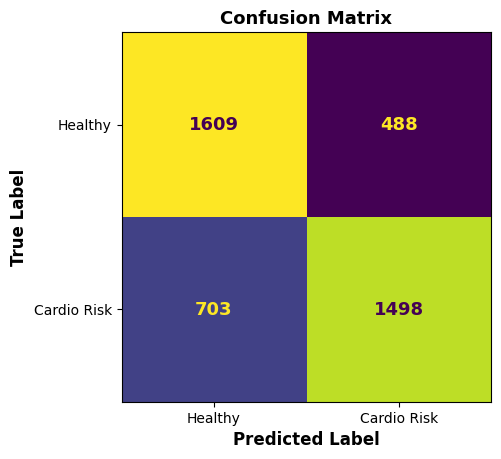

AUC Score on Test Set: 0.7981


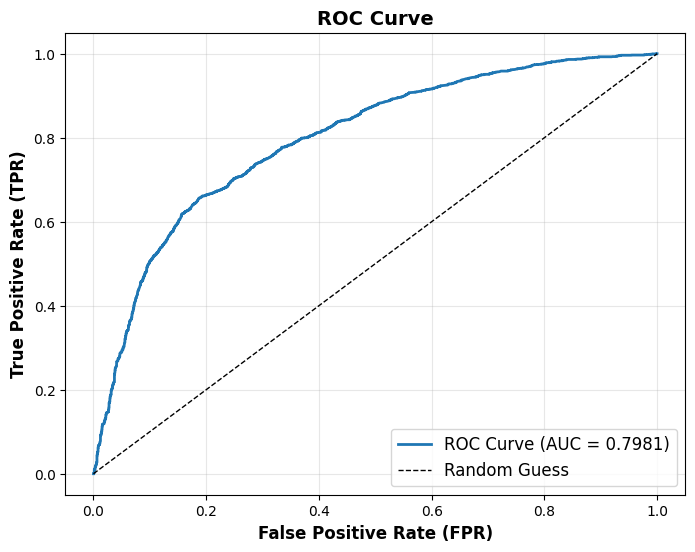

Stacking Model Accuracy on Training Set: 0.7333
AUC Score on Training Set: 0.8020

Overfitting Check:
The model does not show significant signs of overfitting.


In [61]:
# Predictions on the test set
y_pred = stacking_model.predict(x_test_np)
accuracy = accuracy_score(y_test_np, y_pred)
print(f"Stacking Model Accuracy on Test Set: {accuracy:.4f}")

# Classification report
report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

# ROC Curve and AUC Score
y_probs = stacking_model.predict_proba(x_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_np, y_probs)
auc_score = roc_auc_score(y_test_np, y_probs)
print(f"AUC Score on Test Set: {auc_score:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
plt.xlabel("False Positive Rate (FPR)", fontsize=12, fontweight='bold')
plt.ylabel("True Positive Rate (TPR)", fontsize=12, fontweight='bold')
plt.title("ROC Curve", fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Overfitting Check
y_train_pred = stacking_model.predict(x_train_np)
train_accuracy = accuracy_score(y_train_np, y_train_pred)
train_auc_score = roc_auc_score(y_train_np, stacking_model.predict_proba(x_train_np)[:, 1])

print(f"Stacking Model Accuracy on Training Set: {train_accuracy:.4f}")
print(f"AUC Score on Training Set: {train_auc_score:.4f}")

# Compare training and test performance
print("\nOverfitting Check:")
if train_accuracy > accuracy + 0.05 or train_auc_score > auc_score + 0.05:
    print("The model might be overfitting. Training performance is significantly higher than test performance.")
else:
    print("The model does not show significant signs of overfitting.")

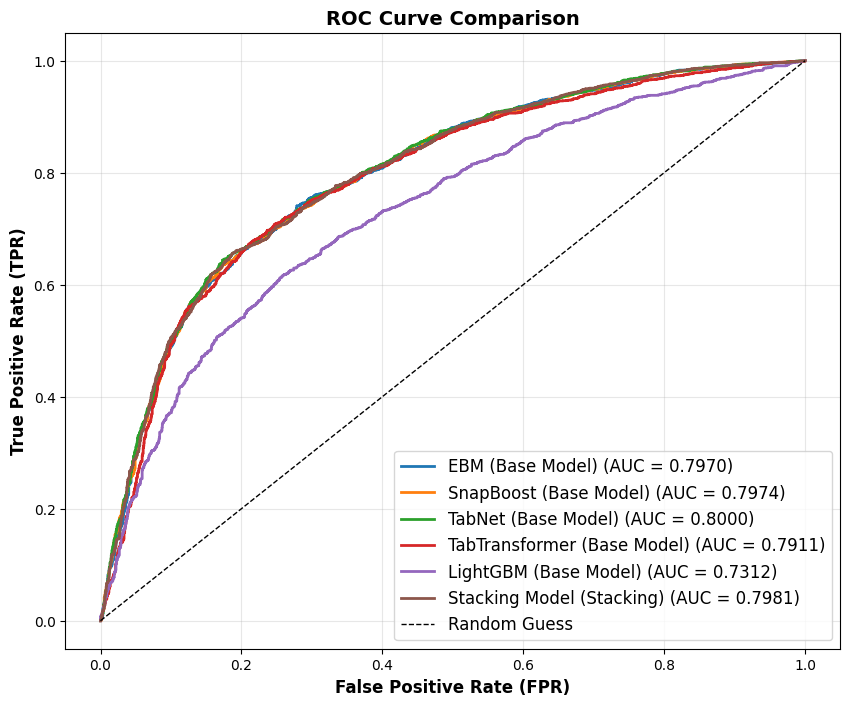

In [72]:
models = {
    "EBM (Base Model)": base_model_ebm.predict_proba(x_test_np)[:, 1],  
    "SnapBoost (Base Model)": base_model_ngb.predict_proba(x_test_np)[:, 1],  
    "TabNet (Base Model)": base_model_snb.predict_proba(x_test_np)[:, 1],
    "TabTransformer (Base Model)": base_model_tabnet.predict_proba(x_test_np)[:, 1],  
    "LightGBM (Base Model)": base_model_tabtf.predict_proba(x_test_np)[:, 1], 
    "Stacking Model (Stacking)": stacking_model.predict_proba(x_test_np)[:, 1],  
}

plt.figure(figsize=(10, 8))

for model_name, y_probs in models.items():
    fpr, tpr, _ = roc_curve(y_test_np, y_probs)
    auc_score = roc_auc_score(y_test_np, y_probs)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)

plt.title("ROC Curve Comparison", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate (FPR)", fontsize=12, fontweight='bold')
plt.ylabel("True Positive Rate (TPR)", fontsize=12, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [63]:
final_model = stacking_model  

model_filename = "../data/final_model.pkl"

# Save the model
with open(model_filename, 'wb') as file:
    pickle.dump(final_model, file)

print(f"Model saved as {model_filename}")

Model saved as ../data/final_model.pkl


In [73]:
# Step 1: Define New Data for Prediction
new_data = pd.DataFrame({
    "age": [43, 50, 51],
    "gender": [2, 1, 1],
    "height": [168, 156, 165],
    "weight": [62.0, 85.0, 64.0],
    "ap_hi": [110, 140, 130],
    "ap_lo": [80, 90, 70],
    "cholesterol": [1, 3, 3],
    "gluc": [1, 1, 3],
    "smoke": [0, 0, 0],
    "alco": [0, 0, 0],
    "active": [1, 1, 1]
})

print("New data for prediction:")
print(new_data)

# Step 2: Load the Saved Model
model_filename = "../data/final_model.pkl"  # Update with your model file path
with open(model_filename, 'rb') as file:
    clf = pickle.load(file)

print("\nModel loaded successfully.")

# Step 3: Preprocess the New Data
# Continuous features that need scaling (update based on your training process)
continuous_features = ["age", "height", "weight", "ap_hi", "ap_lo"]
scaler = StandardScaler()
new_data[continuous_features] = scaler.fit_transform(new_data[continuous_features])  # Use the same scaler logic

# Convert to NumPy array for prediction (Snap ML models require NumPy input)
X_new = new_data.to_numpy()

# Step 4: Predict Using the Model

predictions_numeric = clf.predict(X_new)  # Predict class
predictions_label = [label_mapping[pred] for pred in predictions_numeric]  # Map to labels

New data for prediction:
   age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0   43       2     168    62.0    110     80            1     1      0     0   
1   50       1     156    85.0    140     90            3     1      0     0   
2   51       1     165    64.0    130     70            3     3      0     0   

   active  
0       1  
1       1  
2       1  

Model loaded successfully.


In [74]:
predictions_label

['Healthy', 'Cardio Risk', 'Cardio Risk']